# Deep Learnin project n°1: Image Classification and Regression

**Mathieu Chalvidal**

Master in Applied mathematics and in Artifical intelligence at CentraleSupélec


## **Outline**

The goal of this project is to learn how to implement simple image classification and regression in Keras.
You can refer to the introductory slides on Keras:
https://www.labri.fr/perso/vlepetit/teaching/deep_learning_mva/keras_intro.pdf and of course the online documentation on Keras https://keras.io/.

## Summary:

> 1. Simple classification 
2. A more difficult classification problem
3. Convolutionnal models
4. Regression 
5. Image denoising using Hourglass architecture

### Standard imports

In [1]:
import keras
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
IMAGE_SIZE = 72

Using TensorFlow backend.


### Definition of useful functions

In [220]:
def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]

def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    print('Done')
    return [X, Y]

def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = np_utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    print('Done')
    return [X, Y]

import matplotlib.patches as patches

def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]

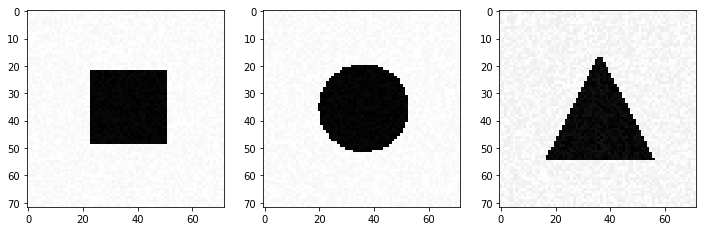

In [76]:
im = generate_a_rectangle(10, False)
im_1 = generate_a_disk(10)
[im_2, v] = generate_a_triangle(20, False)
fig, ax = plt.subplots(1,3, figsize=(12,8))
ax[0].imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
ax[1].imshow(im_1.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
ax[2].imshow(im_2.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.show()

## 1 - Simple classification

In this part, we create a dataset of **300 shapes for the classification problem**. The same linear classification model built with a **categorical cross_entropy loss function** is optimised with 2 different optimizers (SGD and Adam) with **20 epochs** each and **a batch_size of 32**. Afterwards, we compare optimisation performance and display the filters learnt with the 2 optimisers. 

In [77]:
[X_train, Y_train] = generate_dataset_classification(300, 20)

Creating data:
Done


In [78]:
from keras.layers import Dense, Activation
from keras.optimizers import SGD, Adam
nb_neurons = 3

In [79]:
from keras.utils import np_utils
y_train = np_utils.to_categorical(Y_train, 3)

In [107]:
model_SGD = keras.models.Sequential([Dense(nb_neurons, input_shape=(5184,)), Dense(nb_neurons), Dense(3,activation='softmax')])
sgd = SGD(lr=0.001, momentum=0.0, decay=0.0, nesterov=False)
model_SGD.compile(loss='categorical_crossentropy',optimizer=sgd)
hist_1 = model_SGD.fit(X_train, y_train, epochs=20, batch_size=32)

Epoch 1/20
300/300 [==============================] - 0s - loss: 1.0640     
Epoch 2/20
300/300 [==============================] - 0s - loss: 0.9675     
Epoch 3/20
300/300 [==============================] - 0s - loss: 0.9292     
Epoch 4/20
300/300 [==============================] - 0s - loss: 0.8463     
Epoch 5/20
300/300 [==============================] - 0s - loss: 0.8090     
Epoch 6/20
300/300 [==============================] - 0s - loss: 0.7857     
Epoch 7/20
300/300 [==============================] - 0s - loss: 0.7573     
Epoch 8/20
300/300 [==============================] - 0s - loss: 0.7523     
Epoch 9/20
300/300 [==============================] - 0s - loss: 0.7197     
Epoch 10/20
300/300 [==============================] - 0s - loss: 0.6954     
Epoch 11/20
300/300 [==============================] - 0s - loss: 0.6740     
Epoch 12/20
300/300 [==============================] - 0s - loss: 0.6617     
Epoch 13/20
300/300 [==============================] - 0s - loss: 0.6451 

In [108]:
model_Adam = keras.models.Sequential([Dense(nb_neurons, input_shape=(5184,)),Dense(nb_neurons), Dense(3,activation='softmax')])
Adam_= Adam(lr=0.001)
model_Adam.compile(loss='categorical_crossentropy',optimizer=Adam_)
hist_2 = model_Adam.fit(X_train, y_train, epochs=20, batch_size=32, verbose=2)

Epoch 1/20
1s - loss: 2.5243
Epoch 2/20
0s - loss: 1.4700
Epoch 3/20
0s - loss: 0.8992
Epoch 4/20
0s - loss: 0.6708
Epoch 5/20
0s - loss: 0.5878
Epoch 6/20
0s - loss: 0.4703
Epoch 7/20
0s - loss: 0.4392
Epoch 8/20
0s - loss: 0.4156
Epoch 9/20
0s - loss: 0.3739
Epoch 10/20
0s - loss: 0.3496
Epoch 11/20
0s - loss: 0.3090
Epoch 12/20
0s - loss: 0.2782
Epoch 13/20
0s - loss: 0.2554
Epoch 14/20
0s - loss: 0.2452
Epoch 15/20
0s - loss: 0.2461
Epoch 16/20
0s - loss: 0.2058
Epoch 17/20
0s - loss: 0.1808
Epoch 18/20
0s - loss: 0.2000
Epoch 19/20
0s - loss: 0.1547
Epoch 20/20
0s - loss: 0.1450


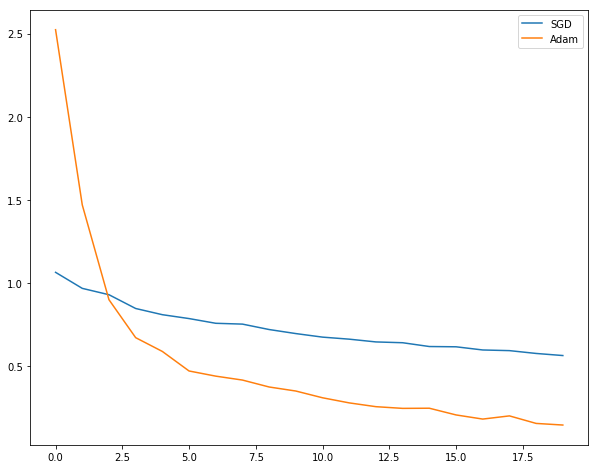

In [109]:
plt.figure(figsize=(10,8))
plt.plot(hist_1.history['loss'], label = "SGD")
plt.plot(hist_2.history['loss'],label = "Adam")
plt.legend()
plt.show()

In [110]:
X_test = generate_a_disk()
X_test = X_test.reshape(1, X_test.shape[0])
print(model_SGD.predict(X_test))

[[0. 1. 0.]]


In [111]:
X_test = generate_a_rectangle()
X_test = X_test.reshape(1, X_test.shape[0])
print(model_Adam.predict(X_test))

[[1. 0. 0.]]


**Interpretation :** It seems that our classifiers are working well to classify the data. However, with no surprise, Adam optimizer seems (here after 20 iterations) faster at converging towards a local minimum 

#### Visualisation of the Solution

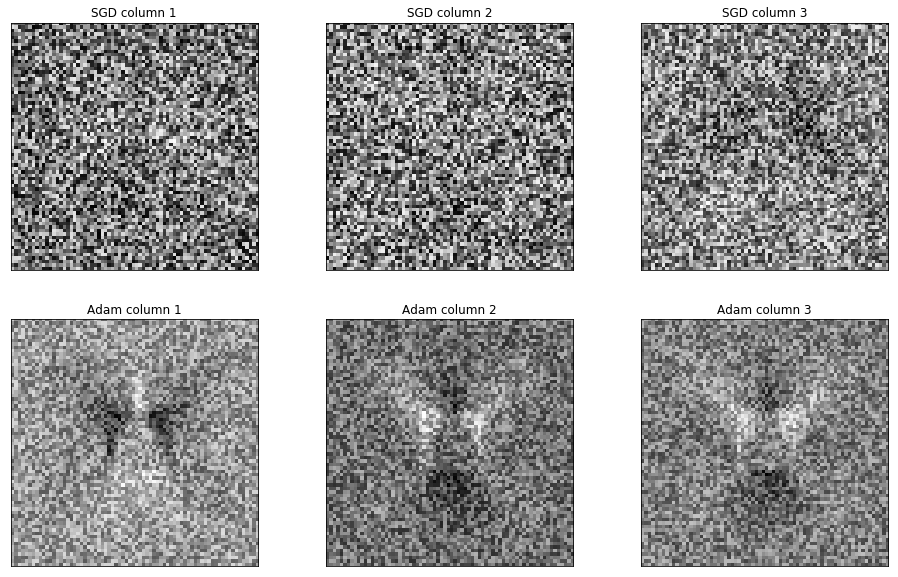

In [112]:
fig, a = plt.subplots(2,3,figsize=(16,10))
for i in range(3):
    a[0,i].imshow(model_SGD.get_weights()[0].T[i].reshape(72,72),cmap='gray' )
    a[0,i].set_xticks([])
    a[0,i].set_yticks([])
    a[0,i].set_title('SGD column {}'.format(i+1))
    
for i in range(3):
    a[1,i].imshow(model_Adam.get_weights()[0].T[i].reshape(72,72),cmap='gray' )
    a[1,i].set_xticks([])
    a[1,i].set_yticks([])
    a[1,i].set_title('Adam column {}'.format(i+1))
    
plt.show()    

## 2 - A more difficult classification problem

#### 1 - Generating training and testing Data

In [204]:
[X_train_2, Y_train_2] = generate_dataset_classification(300, 20, True)

Creating data:
Done


In [221]:
[X_test_2, Y_test_2] = generate_test_set_classification()

Creating data:
Done


#### 2 - Visualising Data

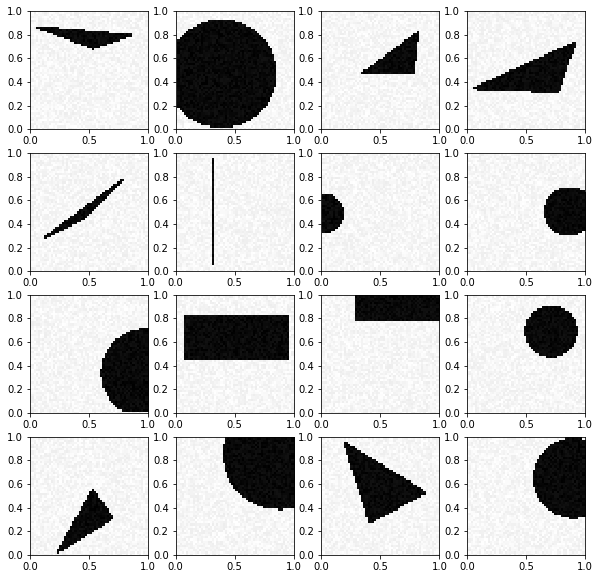

In [206]:
fig, ax = plt.subplots(4,4, figsize=(10, 10))
for i in range(16):
    ax[i//4,i%4].imshow(X_train_2[i].reshape((IMAGE_SIZE,IMAGE_SIZE)), extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax[i//4,i%4].set_xlim([0,1])
    ax[i//4,i%4].set_ylim([0,1])
    
plt.show()

In [213]:
y_train_2 = np_utils.to_categorical(Y_train_2, 3)

#### 3 - Training linear classifier and estimating performance

In [228]:
model_linear = keras.models.Sequential([Dense(nb_neurons, input_shape=(5184,)),Dense(nb_neurons), Dense(3,activation='softmax')])
model_linear.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])
linear_history = model_linear.fit(X_train_2, y_train_2, epochs=200, batch_size=32)

Epoch 1/200
300/300 [==============================] - 2s - loss: 1.3746 - acc: 0.3867     
Epoch 2/200
300/300 [==============================] - 0s - loss: 1.0933 - acc: 0.4167     
Epoch 3/200
300/300 [==============================] - 0s - loss: 1.0169 - acc: 0.4767     
Epoch 4/200
300/300 [==============================] - 0s - loss: 1.0468 - acc: 0.3933     
Epoch 5/200
300/300 [==============================] - 0s - loss: 0.9575 - acc: 0.4967     
Epoch 6/200
300/300 [==============================] - 0s - loss: 0.9047 - acc: 0.5500     
Epoch 7/200
300/300 [==============================] - 0s - loss: 0.8948 - acc: 0.5400     
Epoch 8/200
300/300 [==============================] - 0s - loss: 0.8864 - acc: 0.5667     
Epoch 9/200
300/300 [==============================] - 0s - loss: 0.8945 - acc: 0.5200     
Epoch 10/200
300/300 [==============================] - 0s - loss: 0.8553 - acc: 0.5800     
Epoch 11/200
300/300 [==============================] - 0s - loss: 0.8417 - acc

300/300 [==============================] - 0s - loss: 0.4996 - acc: 0.7800     
Epoch 89/200
300/300 [==============================] - 0s - loss: 0.5020 - acc: 0.7767     
Epoch 90/200
300/300 [==============================] - 0s - loss: 0.4727 - acc: 0.7600     
Epoch 91/200
300/300 [==============================] - 0s - loss: 0.4983 - acc: 0.7467     
Epoch 92/200
300/300 [==============================] - 0s - loss: 0.4469 - acc: 0.8067     
Epoch 93/200
300/300 [==============================] - 0s - loss: 0.4418 - acc: 0.7967     
Epoch 94/200
300/300 [==============================] - 0s - loss: 0.4719 - acc: 0.7633     
Epoch 95/200
300/300 [==============================] - 0s - loss: 0.4261 - acc: 0.8100     
Epoch 96/200
300/300 [==============================] - 0s - loss: 0.4390 - acc: 0.7967     
Epoch 97/200
300/300 [==============================] - 0s - loss: 0.4847 - acc: 0.7200     
Epoch 98/200
300/300 [==============================] - 0s - loss: 0.4595 - acc: 0.

300/300 [==============================] - 0s - loss: 0.2653 - acc: 0.9167     
Epoch 176/200
300/300 [==============================] - 0s - loss: 0.2543 - acc: 0.8867     
Epoch 177/200
300/300 [==============================] - 0s - loss: 0.2303 - acc: 0.9333     
Epoch 178/200
300/300 [==============================] - 0s - loss: 0.2885 - acc: 0.8767     
Epoch 179/200
300/300 [==============================] - 0s - loss: 0.2623 - acc: 0.8733     
Epoch 180/200
300/300 [==============================] - 0s - loss: 0.2147 - acc: 0.9300     
Epoch 181/200
300/300 [==============================] - 0s - loss: 0.2430 - acc: 0.9133     
Epoch 182/200
300/300 [==============================] - 0s - loss: 0.2759 - acc: 0.8833     
Epoch 183/200
300/300 [==============================] - 0s - loss: 0.2541 - acc: 0.8867     
Epoch 184/200
300/300 [==============================] - 0s - loss: 0.2887 - acc: 0.8600     
Epoch 185/200
300/300 [==============================] - 0s - loss: 0.2304

In [234]:
eva = model_linear.evaluate(X_test_2, Y_test_2)
eva

 32/300 [==>...........................] - ETA: 0s

[1.4852886788050335, 0.5699999996026357]

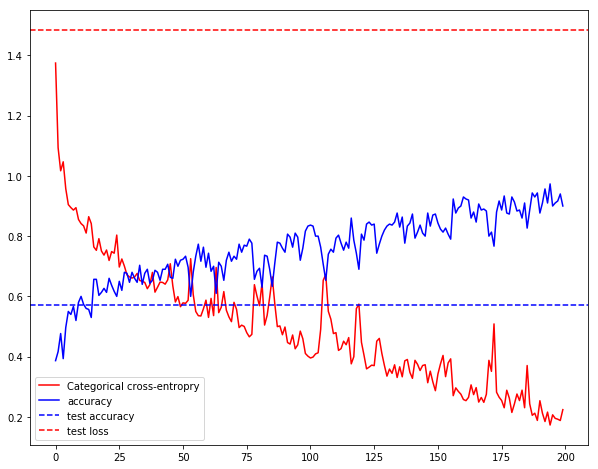

In [238]:
fig, a = plt.subplots(figsize=(10,8))
a.plot(linear_history.history['loss'], color='r', label = "Categorical cross-entropry")
a.plot(linear_history.history['acc'], color= 'b', label = "accuracy")
a.axhline(eva[1],linestyle='--' ,color='b',label='test accuracy')
a.axhline(eva[0],linestyle='--' ,color='r',label='test loss')
a.legend()
plt.show()

The linear classifier performs poorly on the transformed dataset although it seems to progress durint the training. However, the loss function being higher in the test set and accuracy being lower is a sign of **overfitting** during our training. This shows that the linear model has difficulty learning classification rules.

## 3 - Building convolutionnal model

In [239]:
from keras.layers.normalization import BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten

In [240]:
Convolutional = keras.models.Sequential()

Convolutional.add(Conv2D(16, (5, 5), activation='relu', input_shape=(72, 72, 1)))
Convolutional.add(BatchNormalization())
Convolutional.add(Dropout(0.25))
print(Convolutional.output_shape)

Convolutional.add(Conv2D(16, (5, 5), activation='relu', padding='same'))
Convolutional.add(BatchNormalization())
Convolutional.add(Dropout(0.25))
print(Convolutional.output_shape)


Convolutional.add(MaxPooling2D(pool_size=(2, 2)))
Convolutional.add(BatchNormalization())
Convolutional.add(Dropout(0.25))
print(Convolutional.output_shape)

Convolutional.add(Conv2D(16, (5, 5), activation='relu', input_shape=(72, 72, 1)))
Convolutional.add(BatchNormalization())
Convolutional.add(Dropout(0.25))
print(Convolutional.output_shape)

#Convolutional.add(Conv2D(16, (5, 5), activation='relu', padding='same'))
#Convolutional.add(BatchNormalization())
#Convolutional.add(Dropout(0.25))
#print(Convolutional.output_shape)

Convolutional.add(Flatten())
print(Convolutional.output_shape)

Convolutional.add(Dense(3, activation='softmax'))
print(Convolutional.output_shape)

(None, 68, 68, 16)
(None, 68, 68, 16)
(None, 34, 34, 16)
(None, 30, 30, 16)
(None, 14400)
(None, 3)


In [241]:
X_train_2 = X_train_2.reshape(300,72,72,1)
X_test_2 = X_test_2.reshape(300,72,72,1)

In [242]:
Convolutional.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
history = Convolutional.fit(X_train_2, y_train_2, epochs=20, batch_size=32)

Epoch 1/20
300/300 [==============================] - 14s - loss: 1.4626 - acc: 0.5233    
Epoch 2/20
300/300 [==============================] - 11s - loss: 0.6770 - acc: 0.7467    
Epoch 3/20
300/300 [==============================] - 10s - loss: 0.4352 - acc: 0.8267    
Epoch 4/20
300/300 [==============================] - 12s - loss: 0.3078 - acc: 0.8967    
Epoch 5/20
300/300 [==============================] - 11s - loss: 0.1920 - acc: 0.9267    
Epoch 6/20
300/300 [==============================] - 9s - loss: 0.1057 - acc: 0.9500     
Epoch 7/20
300/300 [==============================] - 9s - loss: 0.0705 - acc: 0.9800     
Epoch 8/20
300/300 [==============================] - 10s - loss: 0.0676 - acc: 0.9800    
Epoch 9/20
300/300 [==============================] - 10s - loss: 0.0511 - acc: 0.9800    
Epoch 10/20
300/300 [==============================] - 13s - loss: 0.0523 - acc: 0.9833    
Epoch 11/20
300/300 [==============================] - 12s - loss: 0.0342 - acc: 0.9867  

In [243]:
evaluation = Convolutional.evaluate(X_test_2, Y_test_2)
evaluation

300/300 [==============================] - 6s     


[7.917962697347005, 0.34000000009934106]

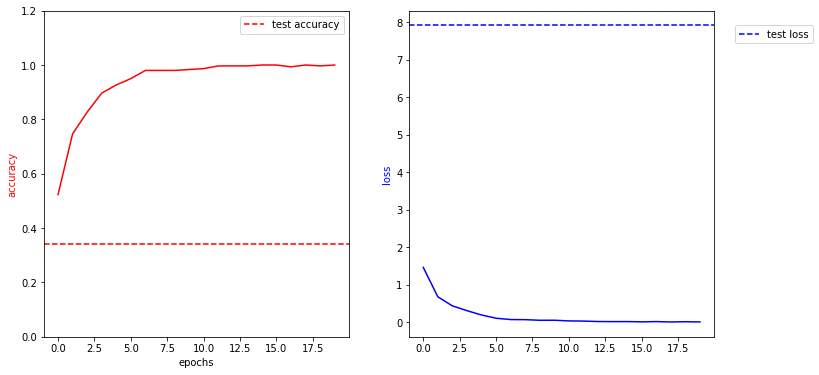

In [244]:
fig, ax = plt.subplots(1,2, figsize=(12,6))
ax[0].plot(history.history['acc'], color = 'r')
ax[0].set_ylabel('accuracy', color='r')
ax[0].set_ylim([0,1.2])
ax[0].set_xlabel('epochs')
ax[0].axhline(evaluation[1],linestyle='--' , color = 'r',label='test accuracy')
ax[0].legend()

ax[1].plot(history.history['loss'], color = 'b')
ax[1].axhline(evaluation[0],linestyle='--' , color = 'b',label='test loss')
ax[1].set_ylabel('loss', color='b')
ax[1].legend(loc=(1.07,0.9))

plt.show()

**Interpretation** Loss and accuracy show considerably poorer performance on the test dataset. This is arguably a mark of **overfitting** of our model on the training dataset. A solution could be to increase the training set in orde to help the model generalize better. 

## 4 - Regression problem

In [129]:
[X_train_reg, Y_train_reg] = generate_dataset_regression(5000, 20)

Creating data:
Done


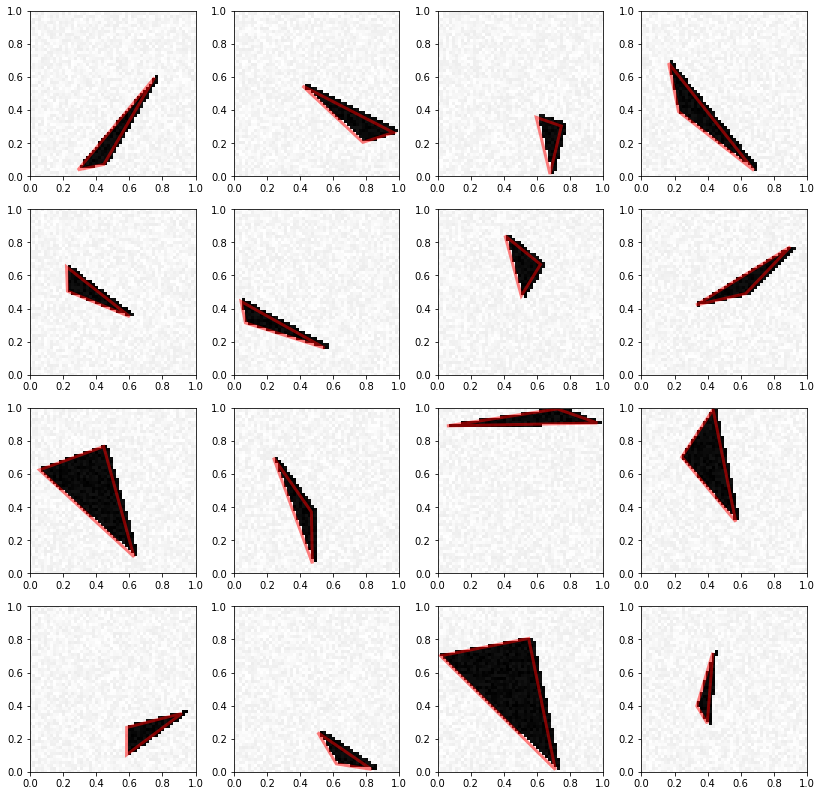

In [131]:
fig, ax = plt.subplots(4,4, figsize=(14, 14))
for i in range(16):
    ax[i//4,i%4].imshow(X_train_reg[i].reshape((IMAGE_SIZE,IMAGE_SIZE)), extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax[i//4,i%4].set_xlim([0,1])
    ax[i//4,i%4].set_ylim([0,1])
    tri = patches.Polygon(Y_train_reg[i].reshape(3,2), closed=True, fill = False, edgecolor = 'r', linewidth = 3, alpha = 0.5)
    ax[i//4,i%4].add_patch(tri) 
plt.show()

In [132]:
[X_test_reg, Y_test_reg] = generate_test_set_regression()

Creating data:
Done


In [133]:
mean = Y_train_reg.mean(axis=0)
std = Y_train_reg.std(axis=0)
max_ = Y_train_reg.max(axis=0)
min_ = Y_train_reg.min(axis=0)
print('Y_train_reg vertices means = {}'.format(mean),'\n')
print('Y_train_reg vertices stds = {}'.format(std),'\n')
print('Y_train_reg vertices maxs = {}'.format(max_),'\n')
print('Y_train_reg vertices mins = {}'.format(min_))

Y_train_reg vertices means = [0.49279733 0.49430772 0.50454065 0.50220873 0.50421655 0.49676233] 

Y_train_reg vertices stds = [0.29186184 0.28954286 0.28585988 0.28668219 0.28940346 0.28837185] 

Y_train_reg vertices maxs = [0.99998541 0.9998811  0.99993714 0.99987971 0.99984558 0.99977424] 

Y_train_reg vertices mins = [9.06635585e-05 3.05947876e-04 1.75835832e-05 3.71714202e-04
 7.57575880e-05 3.02114380e-04]


**NB** : The problem is the randomness of the indices of the vertices generated by the function, in order to learn the relation between the image and the vertices coordinates, we need to sort them in a coherent order.

In [134]:
def order_vertices(Y_data):
    vertices=[]
    for vertice in  Y_data:
        indices = np.zeros(6).astype(int)
        indices[0],indices[2],indices[4] =np.argsort([vertice[0],vertice[2],vertice[4]])*2
        indices[1],indices[3],indices[5] =indices[0]+1,indices[2]+1,indices[4]+1
        vertices.append(vertice[indices])
    vertices = np.array(vertices)
    return vertices
vertices = order_vertices(Y_train_reg)
vertices_test = order_vertices(Y_test_reg)

In [135]:
X_test_reg = X_test_reg.reshape(300,72,72,1)
X_train_reg = X_train_reg.reshape(5000,72,72,1)

In [136]:
from keras import backend as K
from keras.layers import BatchNormalization

def relu_threshold(x):
    return K.relu(x, max_value=1)

In [146]:
#Regression = keras.models.Sequential([Dense(nb_neurons, input_shape=(5184,)),Dense(10,activation='relu'), Dense(6,activation='softmax')])

Regression = keras.models.Sequential()
Regression.add(Conv2D(16, (5, 5), activation='relu', input_shape=(72, 72, 1)))
print(Regression.output_shape)

Regression.add(MaxPooling2D(pool_size=(2, 2)))
Regression.add(Dropout(0.25))
print(Regression.output_shape)

Regression.add(Conv2D(16, (5, 5), activation='relu'))
Regression.add(Dropout(0.25))
print(Regression.output_shape)

Regression.add(Conv2D(16, (5, 5), activation='relu', padding='same'))
Regression.add(Dropout(0.25))
print(Regression.output_shape)

Regression.add(MaxPooling2D(pool_size=(2, 2)))
Regression.add(Dropout(0.25))
print(Regression.output_shape)

Regression.add(Conv2D(16, (5, 5), activation='relu'))
Regression.add(Dropout(0.25))
print(Regression.output_shape)

Regression.add(Conv2D(16, (5, 5), activation='relu', padding='same'))
Regression.add(Dropout(0.25))
print(Regression.output_shape)

Regression.add(Flatten())
print(Regression.output_shape)

Regression.add(Dense(128,activation='relu'))
Regression.add(Dropout(0.25))
print(Regression.output_shape)

Regression.add(Dense(6,activation='relu'))
print(Regression.output_shape)

(None, 68, 68, 16)
(None, 34, 34, 16)
(None, 30, 30, 16)
(None, 30, 30, 16)
(None, 15, 15, 16)
(None, 11, 11, 16)
(None, 11, 11, 16)
(None, 1936)
(None, 128)
(None, 6)


In [147]:
Regression.compile(loss='mean_squared_error',optimizer='adam', metrics=['mae'])
history_reg = Regression.fit(X_train_reg, vertices, validation_data=(X_test_reg,Y_test_reg), epochs=100, verbose=1, batch_size=30)


Train on 5000 samples, validate on 300 samples
Epoch 1/100
5000/5000 [==============================] - 63s - loss: 0.0769 - mean_absolute_error: 0.2225 - val_loss: 0.1039 - val_mean_absolute_error: 0.2631
Epoch 2/100
5000/5000 [==============================] - 55s - loss: 0.0334 - mean_absolute_error: 0.1410 - val_loss: 0.0843 - val_mean_absolute_error: 0.2272
Epoch 3/100
5000/5000 [==============================] - 55s - loss: 0.0235 - mean_absolute_error: 0.1155 - val_loss: 0.0895 - val_mean_absolute_error: 0.2249
Epoch 4/100
5000/5000 [==============================] - 54s - loss: 0.0192 - mean_absolute_error: 0.1038 - val_loss: 0.0902 - val_mean_absolute_error: 0.2258
Epoch 5/100
5000/5000 [==============================] - 54s - loss: 0.0164 - mean_absolute_error: 0.0961 - val_loss: 0.0945 - val_mean_absolute_error: 0.2272
Epoch 6/100
5000/5000 [==============================] - 54s - loss: 0.0145 - mean_absolute_error: 0.0898 - val_loss: 0.0912 - val_mean_absolute_error: 0.2225

5000/5000 [==============================] - 64s - loss: 0.0056 - mean_absolute_error: 0.0547 - val_loss: 0.1030 - val_mean_absolute_error: 0.2218
Epoch 52/100
5000/5000 [==============================] - 65s - loss: 0.0052 - mean_absolute_error: 0.0533 - val_loss: 0.1035 - val_mean_absolute_error: 0.2225
Epoch 53/100
5000/5000 [==============================] - 61s - loss: 0.0051 - mean_absolute_error: 0.0529 - val_loss: 0.1048 - val_mean_absolute_error: 0.2228
Epoch 54/100
5000/5000 [==============================] - 62s - loss: 0.0053 - mean_absolute_error: 0.0532 - val_loss: 0.1045 - val_mean_absolute_error: 0.2235
Epoch 55/100
5000/5000 [==============================] - 59s - loss: 0.0049 - mean_absolute_error: 0.0519 - val_loss: 0.1030 - val_mean_absolute_error: 0.2212
Epoch 56/100
5000/5000 [==============================] - 60s - loss: 0.0051 - mean_absolute_error: 0.0524 - val_loss: 0.1021 - val_mean_absolute_error: 0.2219
Epoch 57/100
5000/5000 [=============================

In [148]:
Predicted = Regression.predict(X_test_reg)

In [149]:
Res = Regression.evaluate(X_test_reg,Y_test_reg)

print('MSE of Test_Set {}'.format(Res[0]))
print('MAE of Test_Set {}'.format(Res[1]))

300/300 [==============================] - 1s     
MSE of Test_Set 0.10686918179194133
MAE of Test_Set 0.22478502710660297


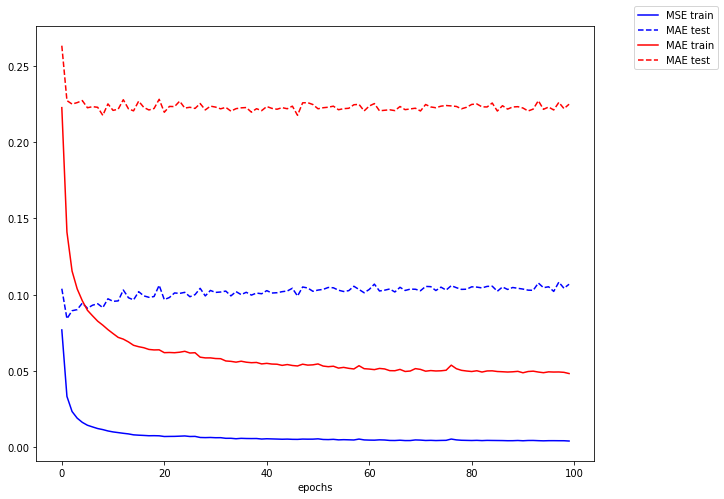

In [150]:
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(history_reg.history['loss'],color='b', label='MSE train')
ax.plot(history_reg.history['val_loss'],color='b',label='MSE test',linestyle='--')
ax.plot(history_reg.history['mean_absolute_error'],color='r',label='MAE train')
ax.plot(history_reg.history['val_mean_absolute_error'],color='r',label='MAE test',linestyle='--' )


#ax.axhline(Res[0],linestyle='--' , color = 'b',label='MSE test set')
#ax.axhline(Res[1],linestyle='--' , color = 'r',label='MAE test set')
ax.legend(loc=(1.07,0.9))
#ax.set_ylim([-0.01,0.2])
ax.set_xlabel('epochs')
plt.show()

**Interpretation**: Althought Mean_squared error and Mean_absolute error were still decreasing during training, the model stopped gaining accuracy on the testing set only after a few iterations. This shows that we could have reduced the number of iterations. Interestingly, mean squarred error of test set is even increasing after to many iterations while mean absolute error remain still. This would leave us thinking that the prediction on three vertices remains the same alltogether but the model performs differently on the different vertices after a certain time.

In [151]:
print(Predicted[0])
print(vertices_test[0],'\n')
print(Predicted[1])
print(vertices_test[1])

[0.34992167 0.32538116 0.72309744 0.24883193 0.96115136 0.9261664 ]
[0.36340393 0.33217252 0.67661723 0.27556678 0.94133439 0.93818117] 

[0.17945528 0.8006253  0.4720077  0.8290756  0.5699778  0.81025743]
[0.17839825 0.77686033 0.49350036 0.81401674 0.51306942 0.78858177]


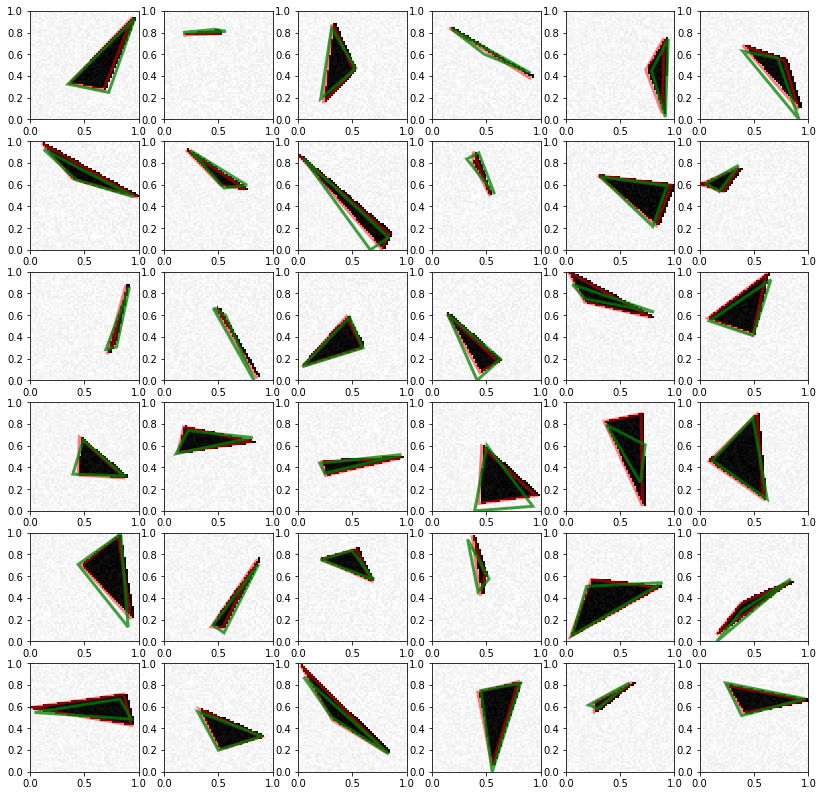

In [152]:
def visualize_pred_16(x, y, y_pred):
    fig, ax = plt.subplots(6,6, figsize=(14, 14))
    for i in range(36):
        ax[i//6,i%6].imshow(x[i].reshape((IMAGE_SIZE,IMAGE_SIZE)), extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
        ax[i//6,i%6].set_xlim([0,1])
        ax[i//6,i%6].set_ylim([0,1])
        tri = patches.Polygon(y[i].reshape(3,2), closed=True, fill = False, edgecolor = 'r', linewidth = 3, alpha = 0.5)
        tri_2 = patches.Polygon(y_pred[i].reshape(3,2), closed=True, fill = False, edgecolor = 'g', linewidth = 3, alpha = 0.75)
        ax[i//6,i%6].add_patch(tri)
        ax[i//6,i%6].add_patch(tri_2)
    plt.show()

visualize_pred_16(X_test_reg, Y_test_reg, Predicted)

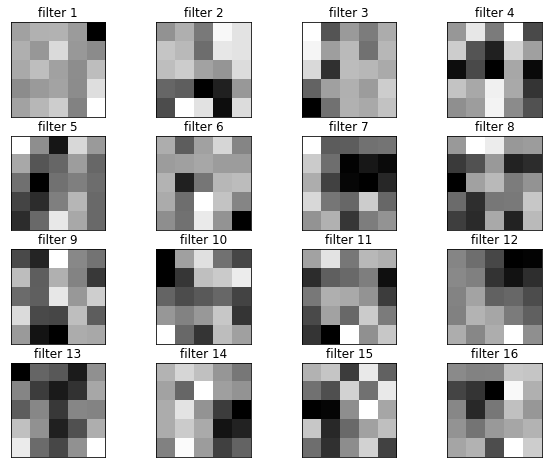

In [154]:
fig, a = plt.subplots(4,4,figsize=(10,8))
for i in range(16):
    a[i//4,i%4].imshow(Regression.get_weights()[0][:,:,0,i],cmap='gray' )
    a[i//4,i%4].set_xticks([])
    a[i//4,i%4].set_yticks([])
    a[i//4,i%4].set_title('filter {}'.format(i+1))
plt.show()

In [155]:
Regression.save_weights('/Users/chalvidalm/Documents/3A OMA/Deep learning/cours 2/Regre.h5')

## 5 - Image Denoising

#### a ) Redifining functions

In [156]:
def generate_a_rectangle_and_noise(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, 0), generate_a_drawing(figsize, U, V, noise)

def generate_a_disk_and_noise(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, 0), generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle_and_noise(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
        generate_a_drawing(figsize, U, V, noise)
    return generate_a_drawing(figsize, U, V, 0), generate_a_drawing(figsize, U, V, noise)

def generate_dataset_noise(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    X_noise = np.zeros([nb_samples,im_size])
    print('Creating data:')
    for i in range(nb_samples):
        category = np.random.randint(3)
        noise_rand = np.random.randint(noise)
        if category == 0:
            X[i], X_noise[i]  = generate_a_rectangle_and_noise(noise_rand, free_location)
        elif category == 1: 
            X[i], X_noise[i] = generate_a_disk_and_noise(noise_rand, free_location)
        else:
            X[i], X_noise[i] = generate_a_triangle_and_noise(noise_rand, free_location)
    print('Done')
    return [X, X_noise]

def generate_test_set_classification():
    np.random.seed(50)
    [X_test, X_noise] = generate_dataset_noise(300, 20, False)
    return [X_test, X_noise]

#### b ) generating data

In [157]:
test = generate_dataset_noise(300,500)

Creating data:
Done


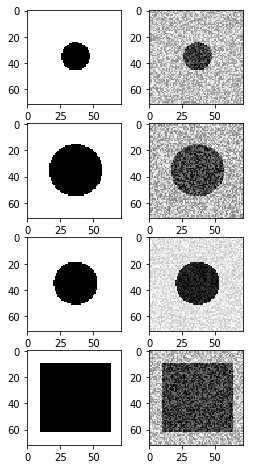

In [158]:
fig, ax = plt.subplots(4,2, figsize=(4,8))
ax[0,0].imshow(test[0][0].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
ax[0,1].imshow(test[1][0].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
ax[1,0].imshow(test[0][1].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
ax[1,1].imshow(test[1][1].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
ax[2,0].imshow(test[0][5].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
ax[2,1].imshow(test[1][5].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
ax[3,0].imshow(test[0][6].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
ax[3,1].imshow(test[1][6].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.show()

In [159]:
X_train_noise = test[1].reshape(300,72,72,1)
X_train_target = test[0].reshape(300,72,72,1)

#### c) Defining a first hourglas model

In [168]:
from keras.layers import Conv2DTranspose
from keras.layers import UpSampling2D

In [180]:
Hourglas = keras.models.Sequential()

Hourglas.add(Conv2D(16, (5, 5), activation='relu', input_shape=(72, 72, 1),padding='same'))
print(Hourglas.output_shape)

Hourglas.add(MaxPooling2D(pool_size=(2, 2)))
Hourglas.add(Dropout(0.25))
print(Hourglas.output_shape)

Hourglas.add(Conv2D(32, (5, 5), activation='relu'))
print(Hourglas.output_shape)

Hourglas.add(MaxPooling2D(pool_size=(2, 2)))
Hourglas.add(Dropout(0.25))
print(Hourglas.output_shape)

Hourglas.add(Conv2D(64, (5, 5), activation='relu',padding='same'))
print(Hourglas.output_shape)

Hourglas.add(UpSampling2D((2, 2),data_format = "channels_last"))
print(Hourglas.output_shape)

Hourglas.add(Conv2DTranspose(32, kernel_size =(5,5), strides=(1,1), data_format = "channels_last",activation='relu'))
Hourglas.add(Dropout(0.25))
print(Hourglas.output_shape)

Hourglas.add(UpSampling2D((2, 2),data_format = "channels_last"))
print(Hourglas.output_shape)

Hourglas.add(Conv2D(16, (5, 5), activation='relu',padding='same'))
print(Hourglas.output_shape)

Hourglas.add(Conv2D(1, (3, 3), activation='relu',padding='same'))
print(Hourglas.output_shape)

Hourglas.add(Conv2D(1, (1, 1), activation='sigmoid' ,padding='same'))
print(Hourglas_2.output_shape)

(None, 72, 72, 16)
(None, 36, 36, 16)
(None, 32, 32, 32)
(None, 16, 16, 32)
(None, 16, 16, 64)
(None, 32, 32, 64)
(None, 36, 36, 32)
(None, 72, 72, 32)
(None, 72, 72, 16)
(None, 72, 72, 1)
(None, 72, 72, 1)


#### d) training the model

In [181]:
Hourglas.compile(loss='mean_squared_error',optimizer='adam')
history_hourglas = Hourglas.fit(X_train_noise, X_train_target/255, epochs=200, verbose=1, batch_size=30)

Epoch 1/200
300/300 [==============================] - 23s - loss: 0.1907    
Epoch 2/200
300/300 [==============================] - 20s - loss: 0.1064    
Epoch 3/200
300/300 [==============================] - 21s - loss: 0.0789    
Epoch 4/200
300/300 [==============================] - 22s - loss: 0.0685    
Epoch 5/200
300/300 [==============================] - 20s - loss: 0.0657    
Epoch 6/200
300/300 [==============================] - 19s - loss: 0.0646    
Epoch 7/200
300/300 [==============================] - 19s - loss: 0.0634    
Epoch 8/200
300/300 [==============================] - 20s - loss: 0.0629    
Epoch 9/200
300/300 [==============================] - 20s - loss: 0.0617    
Epoch 10/200
300/300 [==============================] - 20s - loss: 0.0603    
Epoch 11/200
300/300 [==============================] - 20s - loss: 0.0596    
Epoch 12/200
300/300 [==============================] - 19s - loss: 0.0583    
Epoch 13/200
300/300 [==============================] - 19s -

300/300 [==============================] - 22s - loss: 0.0212    
Epoch 105/200
300/300 [==============================] - 24s - loss: 0.0210    
Epoch 106/200
300/300 [==============================] - 20s - loss: 0.0208    
Epoch 107/200
300/300 [==============================] - 18s - loss: 0.0206    
Epoch 108/200
300/300 [==============================] - 22s - loss: 0.0204    
Epoch 109/200
300/300 [==============================] - 20s - loss: 0.0203    
Epoch 110/200
300/300 [==============================] - 17s - loss: 0.0200    
Epoch 111/200
300/300 [==============================] - 17s - loss: 0.0198    
Epoch 112/200
300/300 [==============================] - 16s - loss: 0.0196    
Epoch 113/200
300/300 [==============================] - 17s - loss: 0.0195    
Epoch 114/200
300/300 [==============================] - 17s - loss: 0.0193    
Epoch 115/200
300/300 [==============================] - 17s - loss: 0.0190    
Epoch 116/200
300/300 [==============================]

In [182]:
Hourglas.save_weights('/Users/chalvidalm/Documents/3A OMA/Deep learning/cours 2/Hourglas_sigm.h5')

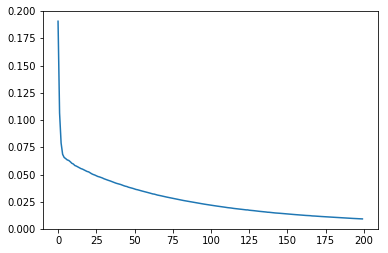

In [183]:
plt.plot(history_hourglas.history['loss'])
plt.show()

In [184]:
denoised = Hourglas.predict(X_train_noise)

#### b) Testing on new noisy data

In [185]:
noise_2 = generate_dataset_noise(20,500)

Creating data:
Done


In [186]:
X_test_noise = noise_2[1].reshape(20,72,72,1)
X_test_target = noise_2[0].reshape(20,72,72,1)
X_test_hourglas = Hourglas.predict(X_test_noise)

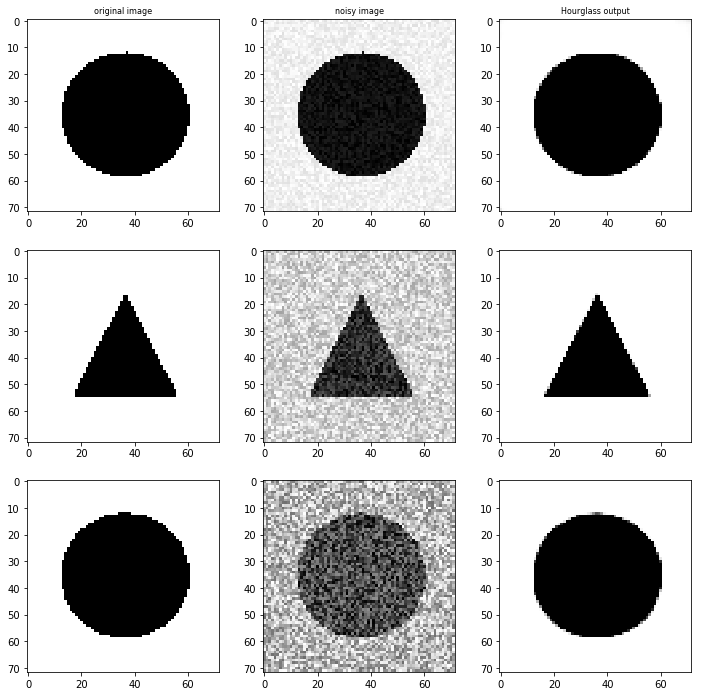

In [189]:
fig, ax = plt.subplots(3,3, figsize=(12,12))
ax[0,0].set_title('original image',size=8)
ax[0,1].set_title('noisy image',size=8)
ax[0,2].set_title('Hourglass output',size=8)
ax[0,2].imshow(X_test_hourglas[1].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
ax[0,0].imshow(X_test_target[1].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
ax[0,1].imshow(X_test_noise[1].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
ax[1,2].imshow(X_test_hourglas[3].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
ax[1,0].imshow(X_test_target[3].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
ax[1,1].imshow(X_test_noise[3].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
ax[2,2].imshow(X_test_hourglas[5].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
ax[2,0].imshow(X_test_target[5].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
ax[2,1].imshow(X_test_noise[5].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.show()